<a href="https://colab.research.google.com/github/TahaErr/Vanilla-supervised-transfer-learning-unsupervised-CV/blob/main/ACV_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMP722 – Assignment Plan (BloodMNIST + Self-Supervised & Fine-Tuning)

## 1. Dataset: BloodMNIST (MedMNIST)

- Domain-specific, medical image dataset.
- ~17k images, **8 classes** (different blood cell types).
- Train/validation/test splits provided by the MedMNIST package.
- Images are small (e.g., 28×28 or 64×64); if single-channel (grayscale), we will convert to 3-channel for ResNet by repeating channels.

**Goal:** Multi-class blood cell classification.

---

## 2. Model Architecture

- Backbone: **ResNet-50** (from `torchvision.models`).
- Output layer: final fully-connected layer adapted to **8 classes**.
- The same architecture is used in all experiments; only the **initialization** changes.

---

## 3. Three Experimental Scenarios (Required by the Assignment)

### Scenario A – Baseline: Training From Scratch

- Initialize ResNet-50 with **random weights** (no pretraining).
- Train on BloodMNIST **train** split with supervised learning.
- This is the **baseline model trained from scratch**.

### Scenario B – Fine-Tuning a Pretrained Model

- Initialize ResNet-50 with **ImageNet-pretrained weights**.
- Replace the final FC layer with a new layer for **8 classes**.
- Fine-tune on BloodMNIST **train** split (full fine-tuning: all layers trainable).
- This implements **“fine-tuning a pretrained model on the chosen dataset.”**

### Scenario C – Self-Supervised Pretraining + Fine-Tuning

Two stages:

1. **Self-Supervised Pretraining (no labels used)**
   - Use the same ResNet-50 backbone (without the classification head).
   - Apply a **SimCLR-style contrastive learning** approach:
     - For each BloodMNIST image, create **two different augmented views**.
     - These two views form a **positive pair**; other images in the batch are **negative examples**.
     - Train with a contrastive loss (e.g., InfoNCE / NT-Xent) to learn good representations.
   - Use BloodMNIST train (and optionally train+val) images as **unlabeled data**.

2. **Fine-Tuning on BloodMNIST Classification**
   - Take the SSL-pretrained ResNet-50 backbone and attach a new **8-class FC head**.
   - Train on BloodMNIST **train** split with supervised learning (CrossEntropy).
   - This implements **“self-supervised pretraining” followed by fine-tuning.**

---

## 4. Data Pipeline

### 4.1. Loading BloodMNIST

- Use the `medmnist` Python package to load:
  - `train`, `val`, and `test` splits for BloodMNIST.
- If images are 1-channel:
  - Convert to 3 channels by repeating: `img = img.repeat(3, 1, 1)`.

### 4.2. Transforms

**For supervised training (Scenarios A, B, C fine-tuning):**

- Training transforms:
  - Random crop / resize (if needed).
  - Random horizontal flip (if appropriate).
  - Normalization (mean/std suitable for the data).
- Validation & test transforms:
  - Resize (if needed) + normalization only.

**For self-supervised pretraining (Scenario C, SSL stage):**

- Stronger augmentations for each view:
  - RandomResizedCrop
  - RandomHorizontalFlip
  - ColorJitter (light)
  - RandomGrayscale
  - (Optionally) GaussianBlur
- DataLoader should return **two augmented views per image**: `(view1, view2)`.

---

## 5. Training Steps

### 5.1. Scenario A – Scratch Supervised Training

1. Create ResNet-50 with **random initialization**, FC → 8 classes.
2. Loss: **CrossEntropyLoss**.
3. Optimizer: e.g. SGD or Adam.
4. Train for a fixed number of epochs (e.g. 50):
   - Log training loss & accuracy.
   - Evaluate on validation set: accuracy + **macro F1-score**.
5. Save the best model (based on validation performance).
6. Evaluate on test set: report test **accuracy** and **macro F1**.

### 5.2. Scenario B – ImageNet-Pretrained Fine-Tuning

1. Create ResNet-50 with **ImageNet-pretrained weights**, replace FC → 8 classes.
2. Use the same data pipeline and similar hyperparameters.
3. Train (full fine-tuning: all layers trainable).
4. Save the best validation model.
5. Evaluate on test set: test accuracy + macro F1.

### 5.3. Scenario C – Self-Supervised Pretraining + Fine-Tuning

**Self-supervised pretraining (SimCLR-style):**

1. Model:
   - ResNet-50 backbone (no classification head).
   - Add a **projection head** (small MLP) on top of the backbone outputs.
2. Training:
   - Use BloodMNIST train images as unlabeled data.
   - For each image, generate two augmented views.
   - Compute contrastive loss (InfoNCE / NT-Xent) so that:
     - Positive pairs (same image) are close in embedding space.
     - Negative pairs (different images) are far apart.
   - Train for N epochs (e.g., similar or more than supervised: 50–100 epochs).
3. After pretraining:
   - Discard the projection head.
   - Keep the backbone weights as **SSL-pretrained initialization**.

**Fine-tuning with labels:**

1. Build a new ResNet-50:
   - Initialize backbone with SSL-pretrained weights.
   - Add new FC layer → 8 classes.
2. Train on BloodMNIST train split with supervised learning (same style as A/B).
3. Save best validation model.
4. Evaluate on test set: test accuracy + macro F1.

---

## 6. Evaluation and Comparison

- Use the **BloodMNIST test set** for final evaluation.
- Metrics:
  - **Accuracy**
  - **Macro F1-score** (important if class distribution is imbalanced).

Create a summary table:

| Model | Initialization            | Method                        | Test Accuracy | Test Macro-F1 |
|------|---------------------------|-------------------------------|---------------|---------------|
| A    | Random                    | From-scratch supervised       |               |               |
| B    | ImageNet-pretrained       | Transfer learning (fine-tune) |               |               |
| C    | BloodMNIST SSL-pretrained | Self-supervised + fine-tune   |               |               |

Short analysis points:
- How much does fine-tuning (B) improve over from-scratch (A)?
- How much does SSL + fine-tuning (C) improve over from-scratch (A)?
- How does SSL (C) compare to ImageNet-pretrained fine-tuning (B)?

---

## 7. Report Structure (Max 5 Pages)

1. **Introduction and Motivation**
   - Brief explanation of representation learning, transfer learning, and self-supervised learning.
   - Why they are useful in medical imaging and small labeled datasets like BloodMNIST.

2. **Dataset Description**
   - BloodMNIST: number of images, classes, resolution.
   - Train/validation/test splits.
   - A few example images per class (optional figure).

3. **Model and Training Details**
   - ResNet-50 architecture and modifications for 8 classes.
   - Description of three scenarios:
     - A: from-scratch supervised
     - B: pretrained fine-tuning
     - C: SSL pretraining + fine-tuning
   - Self-supervised method: short explanation of SimCLR-style contrastive learning and the loss.
   - Training hyperparameters (LR, batch size, epochs, optimizer).

4. **Experimental Results and Analysis**
   - Final table of results (accuracy + macro F1 for A/B/C).
   - Optional training curves or a simple plot.
   - Discussion: which method works best, and why.

5. **Conclusion and Future Work**
   - Summary of main findings.
   - Possible future directions:
     - Larger MedMNIST subsets (PathMNIST, TissueMNIST),
     - Different SSL methods (BYOL, MAE, etc.),
     - Different architectures (ViT, ConvNeXt).

---


In [ ]:
!pip install medmnist


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.7 MB/s eta 0:00:00


In [ ]:
# === Setup & Imports ===
import os
import copy
import time

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

import medmnist
from medmnist import INFO

from sklearn.metrics import f1_score


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


Set the main configuration for  experiments: the BloodMNIST dataset name, batch size, learning rates for supervised and self-supervised training, number of epochs for each phase, and the temperature used in the NT-Xent contrastive loss.


In [ ]:
# === Global configuration ===

DATASET_NAME = 'bloodmnist'   # MedMNIST subset name

BATCH_SIZE   = 128
LR_SUP       = 1e-3           # learning rate for supervised training
LR_SSL       = 1e-3           # learning rate for self-supervised pretraining

EPOCHS_SUP   = 30             # epochs for supervised runs (A, B, C fine-tune)
EPOCHS_SSL   = 50             # epochs for SSL (SimCLR pretraining)
TEMPERATURE  = 0.5            # temperature for NT-Xent loss


This cell loads the BloodMNIST metadata, prints basic dataset information (task, number of channels, classes, label dictionary), and retrieves the corresponding MedMNIST Python dataset class for later data loading.


In [ ]:
# === BloodMNIST metadata & dataset class ===

info = INFO[DATASET_NAME]
print("Dataset info keys:", info.keys())
print("Task:", info['task'])
print("Number of channels:", info['n_channels'])

# Some MedMNIST versions don't store 'n_classes' explicitly,
# but can infer it from the label dict:
n_classes = len(info['label'])
print("Number of classes:", n_classes)

print("Label dict:", info['label'])

n_channels = info['n_channels']

# Get the actual MedMNIST dataset class (e.g., BloodMNIST)
DataClass = getattr(medmnist, info['python_class'])
print("Dataset Python class:", DataClass)


Dataset info keys: dict_keys(['python_class', 'description', 'url', 'MD5', 'url_64', 'MD5_64', 'url_128', 'MD5_128', 'url_224', 'MD5_224', 'task', 'label', 'n_channels', 'n_samples', 'license'])
Task: multi-class
Number of channels: 3
Number of classes: 8
Label dict: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
Dataset Python class: <class 'medmnist.dataset.BloodMNIST'>


In this cell, data transforms for supervised training, validation, and test are defined: images are resized to 64×64, training images get random horizontal flips, all images are converted to tensors, and normalization with mean=0.5 and std=0.5 maps pixel values from [0,1] to [-1,1].


In [ ]:
# === Transforms for supervised training / validation / test ===

mean = [0.5, 0.5, 0.5]
std  = [0.5, 0.5, 0.5]

transform_supervised_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

transform_supervised_eval = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])


This cell creates the supervised training, validation, and test datasets with the defined transforms, wraps them in DataLoaders for batching and shuffling, and prints the number of samples in each split.


In [ ]:
# === Supervised datasets & dataloaders ===

train_dataset_sup = DataClass(
    split='train',
    transform=transform_supervised_train,
    download=True,
    as_rgb=True
)

val_dataset_sup = DataClass(
    split='val',
    transform=transform_supervised_eval,
    download=True,
    as_rgb=True
)

test_dataset_sup = DataClass(
    split='test',
    transform=transform_supervised_eval,
    download=True,
    as_rgb=True
)

train_loader_sup = DataLoader(
    train_dataset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=False
)

val_loader_sup = DataLoader(
    val_dataset_sup,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

test_loader_sup = DataLoader(
    test_dataset_sup,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

print("Train size:", len(train_dataset_sup))
print("Val size:  ", len(val_dataset_sup))
print("Test size: ", len(test_dataset_sup))


Train size: 11959
Val size:   1712
Test size:  3421


3 Chan

In [ ]:
# Quick sanity check: one batch from train loader
images, labels = next(iter(train_loader_sup))
print("Images shape:", images.shape)   # expected: [BATCH_SIZE, 3, 64, 64]
print("Labels shape:", labels.shape)   # expected: [BATCH_SIZE, 1] or [BATCH_SIZE]


Images shape: torch.Size([128, 3, 64, 64])
Labels shape: torch.Size([128, 1])


This cell defines a helper function to evaluate a supervised classification model: it runs the model on a given dataloader, optionally computes the average loss, and returns overall accuracy and macro-averaged F1-score.


In [ ]:
# === Evaluation helper for supervised models ===

def evaluate_supervised(model, dataloader, device, criterion=None):
    """
    Evaluate a classification model on a given dataloader.

    Returns:
        avg_loss  (float or None)  - average loss over the dataset (if criterion is given)
        accuracy (float)          - overall classification accuracy
        macro_f1 (float)          - macro-averaged F1-score
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            # MedMNIST labels are usually shape [B, 1], possibly as uint8
            labels = labels.squeeze().long().to(device)  # -> [B]

            outputs = model(images)  # [B, num_classes]

            if criterion is not None:
                loss = criterion(outputs, labels)
                batch_size = images.size(0)
                total_loss += loss.item() * batch_size
                total_samples += batch_size

            preds = outputs.argmax(dim=1)  # [B]

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    accuracy = (all_preds == all_labels).mean()
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    if criterion is not None and total_samples > 0:
        avg_loss = total_loss / total_samples
    else:
        avg_loss = None

    return avg_loss, accuracy, macro_f1


This cell defines a supervised training loop for classification models. It trains the model with cross-entropy loss and Adam optimizer, evaluates on the validation set each epoch, tracks the best macro-F1 score, and finally restores the weights of the best-performing model.


In [ ]:
# === Supervised training loop for classification (used in Scenarios A, B, C-finetune) ===

def train_supervised_model(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=30,
    lr=1e-3,
    run_name="run"
):
    """
    Train a classification model with supervised learning.

    Args:
        model:       nn.Module, classification model (e.g., ResNet-50).
        train_loader: DataLoader for training data.
        val_loader:   DataLoader for validation data.
        device:       torch.device.
        num_epochs:   number of epochs to train.
        lr:           learning rate.
        run_name:     label to show in logs (e.g., "Scratch", "ImageNet-FT").

    Returns:
        model: the model with the best validation macro-F1 (weights loaded).
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_f1 = 0.0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total_samples = 0

        start_time = time.time()

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size
            preds = outputs.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            total_samples += batch_size

        train_loss = running_loss / total_samples
        train_acc = running_correct / total_samples

        # Validation
        val_loss, val_acc, val_f1 = evaluate_supervised(model, val_loader, device, criterion)

        # Track best model by validation macro-F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())

        elapsed = time.time() - start_time
        print(
            f"[{run_name}] Epoch [{epoch}/{num_epochs}] "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f} "
            f"({elapsed:.1f}s)"
        )

    print(f"[{run_name}] Best Val Macro-F1: {best_val_f1:.4f}")
    model.load_state_dict(best_model_wts)
    return model


This cell defines a helper function that builds a ResNet-50 classifier for BloodMNIST, optionally with ImageNet-pretrained weights, and replaces the final fully connected layer so it outputs num_classes logits.


In [ ]:
# === Helper: create a ResNet-50 classifier for BloodMNIST ===

def create_resnet50_classifier(num_classes, pretrained=False):
    """
    Create a ResNet-50 model for classification on BloodMNIST.

    Args:
        num_classes (int): number of output classes (BloodMNIST -> 8).
        pretrained (bool):
            - True  -> ImageNet-pretrained weights
            - False -> random initialization (from scratch)

    Returns:
        model (nn.Module): ResNet-50 with final FC layer adapted to num_classes.
    """
    weights = ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
    model = resnet50(weights=weights)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model


In this cell, a ResNet-50 classifier (Model A) is created for BloodMNIST using random initialization (no ImageNet pretraining).


In [ ]:
model_a = create_resnet50_classifier(n_classes, pretrained=False)


In this cell, a ResNet-50 classifier (Model B) is created for BloodMNIST using ImageNet-pretrained weights as initialization.


In [ ]:
model_b = create_resnet50_classifier(n_classes, pretrained=True)


This cell runs Scenario A: a ResNet-50 classifier is initialized from scratch, trained on the BloodMNIST train/validation splits with supervised learning, then evaluated on the test set, printing the final test loss, accuracy, and macro-F1 score.


In [ ]:
# === Scenario A: From-scratch supervised training (ResNet-50) ===

# 1) Create a ResNet-50 model with random initialization
model_a = create_resnet50_classifier(num_classes=n_classes, pretrained=False)

# 2) Train the model on BloodMNIST train/val splits
model_a = train_supervised_model(
    model=model_a,
    train_loader=train_loader_sup,
    val_loader=val_loader_sup,
    device=DEVICE,
    num_epochs=EPOCHS_SUP,
    lr=LR_SUP,
    run_name="Scratch-ResNet50"
)

# 3) Evaluate on the test set
criterion = nn.CrossEntropyLoss()
test_loss_a, test_acc_a, test_f1_a = evaluate_supervised(
    model=model_a,
    dataloader=test_loader_sup,
    device=DEVICE,
    criterion=criterion
)

print(f"[Scratch-ResNet50] Test Loss: {test_loss_a:.4f} | "
      f"Test Acc: {test_acc_a:.4f} | Test Macro-F1: {test_f1_a:.4f}")


[Scratch-ResNet50] Epoch [1/30] Train Loss: 0.8057 Acc: 0.7156 | Val Loss: 0.5042 Acc: 0.8166 F1: 0.7858 (5.5s)
[Scratch-ResNet50] Epoch [2/30] Train Loss: 0.3822 Acc: 0.8657 | Val Loss: 0.5853 Acc: 0.8143 F1: 0.7692 (3.4s)
[Scratch-ResNet50] Epoch [3/30] Train Loss: 0.3073 Acc: 0.8935 | Val Loss: 0.3326 Acc: 0.8727 F1: 0.8446 (3.5s)
[Scratch-ResNet50] Epoch [4/30] Train Loss: 0.2601 Acc: 0.9105 | Val Loss: 0.3620 Acc: 0.8773 F1: 0.8541 (3.4s)
[Scratch-ResNet50] Epoch [5/30] Train Loss: 0.2177 Acc: 0.9213 | Val Loss: 0.2384 Acc: 0.9211 F1: 0.9106 (3.4s)
[Scratch-ResNet50] Epoch [6/30] Train Loss: 0.1823 Acc: 0.9369 | Val Loss: 0.4954 Acc: 0.8505 F1: 0.8120 (3.5s)
[Scratch-ResNet50] Epoch [7/30] Train Loss: 0.1701 Acc: 0.9397 | Val Loss: 0.4769 Acc: 0.8505 F1: 0.8242 (3.4s)
[Scratch-ResNet50] Epoch [8/30] Train Loss: 0.1607 Acc: 0.9434 | Val Loss: 0.3023 Acc: 0.8908 F1: 0.8874 (3.4s)
[Scratch-ResNet50] Epoch [9/30] Train Loss: 0.1386 Acc: 0.9512 | Val Loss: 0.2731 Acc: 0.9136 F1: 0.9038

This cell runs Scenario B: a ResNet-50 with ImageNet-pretrained weights is fine-tuned on the BloodMNIST train/validation splits and then evaluated on the test set, printing test loss, accuracy, and macro-F1.


In [ ]:
# === Scenario B: ImageNet-pretrained fine-tuning (ResNet-50) ===

# 1) Create a ResNet-50 model with ImageNet-pretrained weights
model_b = create_resnet50_classifier(num_classes=n_classes, pretrained=True)

# 2) Fine-tune the model on BloodMNIST train/val splits
model_b = train_supervised_model(
    model=model_b,
    train_loader=train_loader_sup,
    val_loader=val_loader_sup,
    device=DEVICE,
    num_epochs=EPOCHS_SUP,
    lr=LR_SUP,
    run_name="ImageNetFT-ResNet50"
)

# 3) Evaluate on the test set
criterion = nn.CrossEntropyLoss()
test_loss_b, test_acc_b, test_f1_b = evaluate_supervised(
    model=model_b,
    dataloader=test_loader_sup,
    device=DEVICE,
    criterion=criterion
)

print(f"[ImageNetFT-ResNet50] Test Loss: {test_loss_b:.4f} | "
      f"Test Acc: {test_acc_b:.4f} | Test Macro-F1: {test_f1_b:.4f}")


[ImageNetFT-ResNet50] Epoch [1/30] Train Loss: 0.3875 Acc: 0.8653 | Val Loss: 0.4623 Acc: 0.8738 F1: 0.8572 (3.5s)
[ImageNetFT-ResNet50] Epoch [2/30] Train Loss: 0.2000 Acc: 0.9288 | Val Loss: 0.2426 Acc: 0.9153 F1: 0.9027 (3.5s)
[ImageNetFT-ResNet50] Epoch [3/30] Train Loss: 0.1530 Acc: 0.9464 | Val Loss: 0.2714 Acc: 0.9124 F1: 0.8947 (3.5s)
[ImageNetFT-ResNet50] Epoch [4/30] Train Loss: 0.1561 Acc: 0.9472 | Val Loss: 0.1635 Acc: 0.9463 F1: 0.9406 (3.5s)
[ImageNetFT-ResNet50] Epoch [5/30] Train Loss: 0.1240 Acc: 0.9579 | Val Loss: 0.1543 Acc: 0.9492 F1: 0.9458 (3.5s)
[ImageNetFT-ResNet50] Epoch [6/30] Train Loss: 0.1038 Acc: 0.9615 | Val Loss: 0.1801 Acc: 0.9468 F1: 0.9412 (3.7s)
[ImageNetFT-ResNet50] Epoch [7/30] Train Loss: 0.1005 Acc: 0.9657 | Val Loss: 0.1518 Acc: 0.9521 F1: 0.9492 (3.5s)
[ImageNetFT-ResNet50] Epoch [8/30] Train Loss: 0.0794 Acc: 0.9730 | Val Loss: 0.1717 Acc: 0.9504 F1: 0.9460 (3.4s)
[ImageNetFT-ResNet50] Epoch [9/30] Train Loss: 0.0615 Acc: 0.9784 | Val Loss: 0.

This cell defines data augmentations for self-supervised SimCLR-style pretraining on BloodMNIST: images are resized, randomly cropped, flipped, color-jittered, optionally converted to grayscale, then turned into tensors and normalized with mean=0.5 and std=0.5 to map pixel values from [0,1] to [-1,1].


In [ ]:
# === SSL transforms for self-supervised pretraining (SimCLR-style) ===
# MedMNIST (as_rgb=True) already returns PIL.Image

ssl_mean = [0.5, 0.5, 0.5]
ssl_std  = [0.5, 0.5, 0.5]

transform_ssl = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomResizedCrop(64, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply(
        [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)],
        p=0.8
    ),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=ssl_mean, std=ssl_std),
])


This dataset wrapper takes each original image and generates two independently augmented views (v1, v2). These two views form a positive pair for SimCLR-style contrastive learning, encouraging the encoder to produce similar representations for different augmentations of the same image.



In [ ]:
# === SSLWrapperDataset: returns two augmented views (v1, v2) of each image ===

class SSLWrapperDataset(Dataset):
    """
    Wraps a MedMNIST dataset and returns two augmented views (v1, v2)
    of the same underlying image. The label from the base dataset is ignored.
    """
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # base_dataset returns (PIL.Image, label)
        img, _ = self.base_dataset[idx]
        v1 = self.transform(img)
        v2 = self.transform(img)
        return v1, v2


This cell builds the self-supervised dataset and DataLoader from the BloodMNIST train split using the SSL wrapper (which returns two augmented views per image), then prints the dataset size and checks that both views in a batch have the expected shape [BATCH_SIZE, 3, 64, 64].


In [ ]:
# === Build SSL dataset and dataloader using BloodMNIST train split ===

ssl_base_dataset = DataClass(
    split='train',
    transform=None,   # apply transform_ssl INSIDE the wrapper
    download=True,
    as_rgb=True
)

ssl_dataset = SSLWrapperDataset(ssl_base_dataset, transform_ssl)

ssl_loader = DataLoader(
    ssl_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True   # SimCLR usually uses drop_last=True for nice 2B batches
)

print("SSL dataset size:", len(ssl_dataset))

# Quick sanity check: grab one batch
v1, v2 = next(iter(ssl_loader))
print("v1 shape:", v1.shape)  # expected: [BATCH_SIZE, 3, 64, 64]
print("v2 shape:", v2.shape)  # same as v1


SSL dataset size: 11959
v1 shape: torch.Size([128, 3, 64, 64])
v2 shape: torch.Size([128, 3, 64, 64])


This cell defines a SimCLR self-supervised model that uses a ResNet-50 backbone (with its final FC layer replaced by an identity layer) plus an MLP projection head, returning backbone features h and projected features z for contrastive learning.


In [ ]:
# === SimCLR model: ResNet-50 backbone + projection head ===

class SimCLRResNet50(nn.Module):
    """
    Self-supervised model for SimCLR:
    - Uses a ResNet-50 backbone (same architecture as our classifier).
    - Replaces the final FC layer with Identity to get feature vectors.
    - Adds a small projection head on top for contrastive learning.
    """
    def __init__(self, feature_dim=128):
        super().__init__()

        # ResNet-50 backbone, random init (we will train it with SSL)
        self.backbone = resnet50(weights=None)
        in_features = self.backbone.fc.in_features

        # Classification head is not used in SSL, so we replace it with Identity
        self.backbone.fc = nn.Identity()

        # Projection head for SimCLR (used only during SSL pretraining)
        self.projection_head = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(inplace=True),
            nn.Linear(in_features, feature_dim)
        )

    def forward(self, x):
        """
        Args:
            x: input images [B, 3, 64, 64]

        Returns:
            h: backbone features [B, in_features]
            z: projected features for contrastive loss [B, feature_dim]
        """
        h = self.backbone(x)          # [B, in_features]
        z = self.projection_head(h)   # [B, feature_dim]
        return h, z


This cell performs a quick sanity check for the SimCLRResNet50 model by running one SSL batch through it and printing the shapes of the backbone features h and projected features z to confirm they have the expected dimensions.


In [ ]:
# Quick sanity check for SimCLRResNet50
simclr_model = SimCLRResNet50(feature_dim=128).to(DEVICE)
v1, v2 = next(iter(ssl_loader))  # from previous step
v1 = v1.to(DEVICE)
with torch.no_grad():
    h, z = simclr_model(v1)
print("h shape:", h.shape)  # [B, in_features] (genelde [B, 2048])
print("z shape:", z.shape)  # [B, 128]


h shape: torch.Size([128, 2048])
z shape: torch.Size([128, 128])


This cell implements the SimCLR NT-Xent contrastive loss: it L2-normalizes the concatenated projections from two views, computes a cosine similarity matrix scaled by the temperature, and for each embedding treats its counterpart from the other view as the positive example while all remaining embeddings act as negatives.


In [ ]:
# === NT-Xent loss (SimCLR-style contrastive loss) ===

def nt_xent_loss(z, temperature=0.5):
    """
    Normalized Temperature-scaled Cross Entropy (NT-Xent) loss used in SimCLR.

    Args:
        z: tensor of shape [2*B, D]
           Concatenation of projections for two views:
               z = torch.cat([z1, z2], dim=0)
           where z1, z2 come from the same batch of size B.
        temperature: scalar temperature parameter (tau).

    Returns:
        loss: scalar contrastive loss.
    """
    # L2-normalize embeddings along feature dimension
    z = F.normalize(z, dim=1)

    N = z.size(0)           # N = 2 * B
    assert N % 2 == 0, "NT-Xent expects an even batch size after concatenation."
    B = N // 2

    # Cosine similarity matrix (N x N)
    sim = torch.matmul(z, z.T)  # [N, N]
    sim = sim / temperature

    # Remove self-similarity on the diagonal
    mask = torch.eye(N, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, float('-inf'))

    # For each i, the positive example index is (i + B) % N
    pos_idx = torch.arange(N, device=z.device)
    pos_idx = (pos_idx + B) % N

    # Cross-entropy loss: for each i, classify its positive index
    loss = F.cross_entropy(sim, pos_idx)

    return loss


This cell trains the SimCLRResNet50 model in a self-supervised way: for each epoch it takes pairs of augmented views from the SSL DataLoader, computes the NT-Xent contrastive loss on their projections, updates the model with Adam, and prints the epoch loss.


In [ ]:
# === Self-supervised training loop for SimCLR (ResNet-50 backbone) ===

def train_simclr(
    model,
    ssl_loader,
    device,
    num_epochs=EPOCHS_SSL,
    lr=LR_SSL,
    temperature=TEMPERATURE
):
    """
    Train a SimCLRResNet50 model in a self-supervised way on unlabeled data.

    Args:
        model:       SimCLRResNet50 instance.
        ssl_loader:  DataLoader that yields (v1, v2) augmented views.
        device:      torch.device.
        num_epochs:  number of SSL epochs.
        lr:          learning rate for optimizer.
        temperature: NT-Xent temperature.

    Returns:
        model: the SSL-pretrained SimCLRResNet50 model.
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        total_samples = 0

        start_time = time.time()

        for v1, v2 in ssl_loader:
            v1 = v1.to(device)
            v2 = v2.to(device)
            batch_size = v1.size(0)

            optimizer.zero_grad()

            # Forward both views through SimCLR model
            _, z1 = model(v1)   # z1: [B, D]
            _, z2 = model(v2)   # z2: [B, D]

            # Concatenate projections: [2B, D]
            z = torch.cat([z1, z2], dim=0)

            # Contrastive loss
            loss = nt_xent_loss(z, temperature=temperature)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_size
            total_samples += batch_size

        epoch_loss = running_loss / total_samples
        elapsed = time.time() - start_time

        print(f"[SimCLR] Epoch [{epoch}/{num_epochs}] "
              f"Loss: {epoch_loss:.4f} ({elapsed:.1f}s)")

    print("[SimCLR] Self-supervised pretraining finished.")
    return model


This cell runs Scenario C (a): it creates a SimCLR model with a ResNet-50 backbone, performs self-supervised pretraining on the unlabeled BloodMNIST train split, and then extracts the SSL-pretrained backbone weights.


In [ ]:
# === Scenario C (a): Self-supervised pretraining with SimCLR (ResNet-50) ===

# 1) Create SimCLR model with ResNet-50 backbone
simclr_model = SimCLRResNet50(feature_dim=128)

# 2) Train SimCLR on BloodMNIST train split (unlabeled)
simclr_model = train_simclr(
    model=simclr_model,
    ssl_loader=ssl_loader,
    device=DEVICE,
    num_epochs=EPOCHS_SSL,
    lr=LR_SSL,
    temperature=TEMPERATURE
)

# 3) Extract the SSL-pretrained backbone weights
ssl_backbone_state = simclr_model.backbone.state_dict()
print("SSL backbone state dict keys (sample):", list(ssl_backbone_state.keys())[:5])


[SimCLR] Epoch [1/50] Loss: 5.1139 (17.0s)
[SimCLR] Epoch [2/50] Loss: 4.5935 (16.8s)
[SimCLR] Epoch [3/50] Loss: 4.4839 (16.7s)
[SimCLR] Epoch [4/50] Loss: 4.3915 (16.8s)
[SimCLR] Epoch [5/50] Loss: 4.2299 (17.1s)
[SimCLR] Epoch [6/50] Loss: 4.1511 (17.0s)
[SimCLR] Epoch [7/50] Loss: 4.0975 (17.2s)
[SimCLR] Epoch [8/50] Loss: 4.0633 (16.7s)
[SimCLR] Epoch [9/50] Loss: 4.0364 (16.7s)
[SimCLR] Epoch [10/50] Loss: 4.0115 (16.7s)
[SimCLR] Epoch [11/50] Loss: 3.9723 (17.0s)
[SimCLR] Epoch [12/50] Loss: 3.9416 (16.6s)
[SimCLR] Epoch [13/50] Loss: 3.9206 (16.7s)
[SimCLR] Epoch [14/50] Loss: 3.9003 (16.8s)
[SimCLR] Epoch [15/50] Loss: 3.8823 (16.7s)
[SimCLR] Epoch [16/50] Loss: 3.8640 (16.9s)
[SimCLR] Epoch [17/50] Loss: 3.8544 (16.7s)
[SimCLR] Epoch [18/50] Loss: 3.8378 (16.7s)
[SimCLR] Epoch [19/50] Loss: 3.8332 (16.9s)
[SimCLR] Epoch [20/50] Loss: 3.8190 (16.7s)
[SimCLR] Epoch [21/50] Loss: 3.8161 (16.8s)
[SimCLR] Epoch [22/50] Loss: 3.8047 (16.8s)
[SimCLR] Epoch [23/50] Loss: 3.7972 (17.0

This cell runs Scenario C (b): a new ResNet-50 classifier is created, its backbone is initialized with the SSL-pretrained weights (while the final FC layer stays randomly initialized), then it is fine-tuned on the BloodMNIST train/validation splits and evaluated on the test set, printing test loss, accuracy, and macro-F1.


In [ ]:
# === Scenario C (b): Supervised fine-tuning with SSL-pretrained ResNet-50 ===

# 1) Create a fresh ResNet-50 classifier (FC -> 8 classes), without any pretrained weights
model_c = create_resnet50_classifier(num_classes=n_classes, pretrained=False)

# 2) Load the SSL-pretrained backbone weights into this classifier model
#    strict=False so that the classification head (fc) is left untouched.
model_c.load_state_dict(ssl_backbone_state, strict=False)

# 3) Supervised fine-tuning on BloodMNIST train/val splits
model_c = train_supervised_model(
    model=model_c,
    train_loader=train_loader_sup,
    val_loader=val_loader_sup,
    device=DEVICE,
    num_epochs=EPOCHS_SUP,
    lr=LR_SUP,
    run_name="SSL+FT-ResNet50"
)

# 4) Evaluate on the test set
criterion = nn.CrossEntropyLoss()
test_loss_c, test_acc_c, test_f1_c = evaluate_supervised(
    model=model_c,
    dataloader=test_loader_sup,
    device=DEVICE,
    criterion=criterion
)

print(f"[SSL+FT-ResNet50] Test Loss: {test_loss_c:.4f} | "
      f"Test Acc: {test_acc_c:.4f} | Test Macro-F1: {test_f1_c:.4f}")


[SSL+FT-ResNet50] Epoch [1/30] Train Loss: 0.4976 Acc: 0.8222 | Val Loss: 0.5781 Acc: 0.8277 F1: 0.8018 (3.4s)
[SSL+FT-ResNet50] Epoch [2/30] Train Loss: 0.3172 Acc: 0.8881 | Val Loss: 0.3229 Acc: 0.8803 F1: 0.8656 (3.5s)
[SSL+FT-ResNet50] Epoch [3/30] Train Loss: 0.2501 Acc: 0.9146 | Val Loss: 0.3636 Acc: 0.8709 F1: 0.8445 (3.4s)
[SSL+FT-ResNet50] Epoch [4/30] Train Loss: 0.1973 Acc: 0.9300 | Val Loss: 0.4694 Acc: 0.8680 F1: 0.8332 (3.4s)
[SSL+FT-ResNet50] Epoch [5/30] Train Loss: 0.1656 Acc: 0.9416 | Val Loss: 0.1491 Acc: 0.9480 F1: 0.9424 (3.5s)
[SSL+FT-ResNet50] Epoch [6/30] Train Loss: 0.1473 Acc: 0.9479 | Val Loss: 0.1674 Acc: 0.9410 F1: 0.9341 (3.4s)
[SSL+FT-ResNet50] Epoch [7/30] Train Loss: 0.1395 Acc: 0.9496 | Val Loss: 0.2385 Acc: 0.9153 F1: 0.8958 (3.3s)
[SSL+FT-ResNet50] Epoch [8/30] Train Loss: 0.1175 Acc: 0.9588 | Val Loss: 0.5798 Acc: 0.8364 F1: 0.8139 (3.3s)
[SSL+FT-ResNet50] Epoch [9/30] Train Loss: 0.1131 Acc: 0.9592 | Val Loss: 0.2011 Acc: 0.9322 F1: 0.9244 (3.6s)
[

In [ ]:
# === Summary table: Scratch vs ImageNet-FT vs SSL+FT ===

import pandas as pd

results = [
    {
        "Scenario": "A - Scratch",
        "Init": "Random (ResNet-50)",
        "Method": "From-scratch supervised",
        "Test Accuracy": test_acc_a,
        "Test Macro-F1": test_f1_a,
    },
    {
        "Scenario": "B - ImageNet-FT",
        "Init": "ImageNet-pretrained (ResNet-50)",
        "Method": "Transfer learning (fine-tune)",
        "Test Accuracy": test_acc_b,
        "Test Macro-F1": test_f1_b,
    },
    {
        "Scenario": "C - SSL+FT",
        "Init": "SSL-pretrained on BloodMNIST (ResNet-50)",
        "Method": "Self-supervised pretrain + fine-tune",
        "Test Accuracy": test_acc_c,
        "Test Macro-F1": test_f1_c,
    },
]

df_results = pd.DataFrame(results)
df_results


,Scenario,Init,Method,Test Accuracy,Test Macro-F1
0,A - Scratch,Random (ResNet-50),From-scratch supervised,0.936568,0.928971
1,B - ImageNet-FT,ImageNet-pretrained (ResNet-50),Transfer learning (fine-tune),0.961707,0.958843
2,C - SSL+FT,SSL-pretrained on BloodMNIST (ResNet-50),Self-supervised pretrain + fine-tune,0.959076,0.953349


In [ ]:
# === Final evaluation: all models on TEST set only ===

criterion = nn.CrossEntropyLoss()

# Scenario A: Scratch
test_loss_a, test_acc_a, test_f1_a = evaluate_supervised(
    model=model_a,
    dataloader=test_loader_sup,
    device=DEVICE,
    criterion=criterion
)

# Scenario B: ImageNet-FT
test_loss_b, test_acc_b, test_f1_b = evaluate_supervised(
    model=model_b,
    dataloader=test_loader_sup,
    device=DEVICE,
    criterion=criterion
)

# Scenario C: SSL+FT
test_loss_c, test_acc_c, test_f1_c = evaluate_supervised(
    model=model_c,
    dataloader=test_loader_sup,
    device=DEVICE,
    criterion=criterion
)

print("=== TEST SET RESULTS ===")
print(f"Scenario A - Scratch (ResNet-50)")
print(f"  Test Loss    : {test_loss_a:.4f}")
print(f"  Test Accuracy: {test_acc_a:.4f}")
print(f"  Test Macro-F1: {test_f1_a:.4f}")
print()
print(f"Scenario B - ImageNet-FT (ResNet-50)")
print(f"  Test Loss    : {test_loss_b:.4f}")
print(f"  Test Accuracy: {test_acc_b:.4f}")
print(f"  Test Macro-F1: {test_f1_b:.4f}")
print()
print(f"Scenario C - SSL+FT (ResNet-50)")
print(f"  Test Loss    : {test_loss_c:.4f}")
print(f"  Test Accuracy: {test_acc_c:.4f}")
print(f"  Test Macro-F1: {test_f1_c:.4f}")


=== TEST SET RESULTS ===
Scenario A - Scratch (ResNet-50)
  Test Loss    : 0.2291
  Test Accuracy: 0.9366
  Test Macro-F1: 0.9290

Scenario B - ImageNet-FT (ResNet-50)
  Test Loss    : 0.1970
  Test Accuracy: 0.9617
  Test Macro-F1: 0.9588

Scenario C - SSL+FT (ResNet-50)
  Test Loss    : 0.1708
  Test Accuracy: 0.9591
  Test Macro-F1: 0.9533


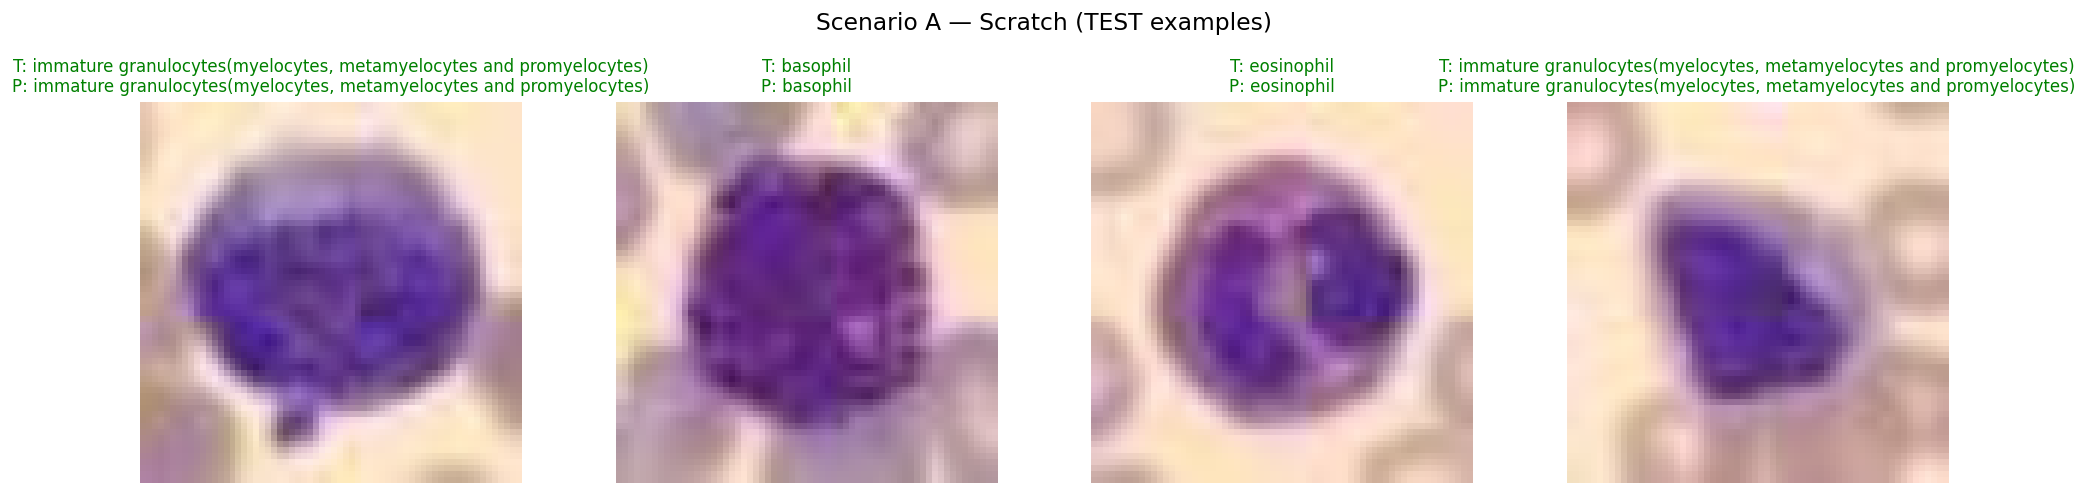

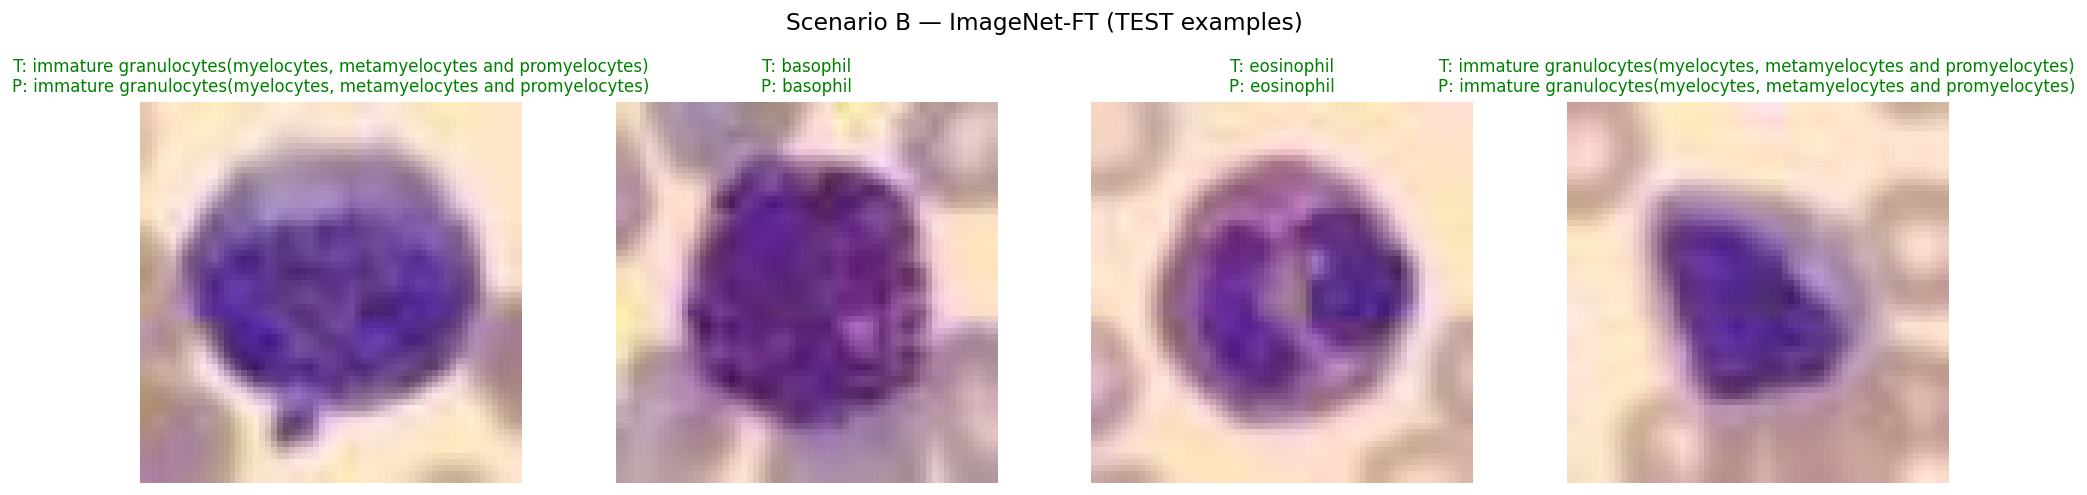

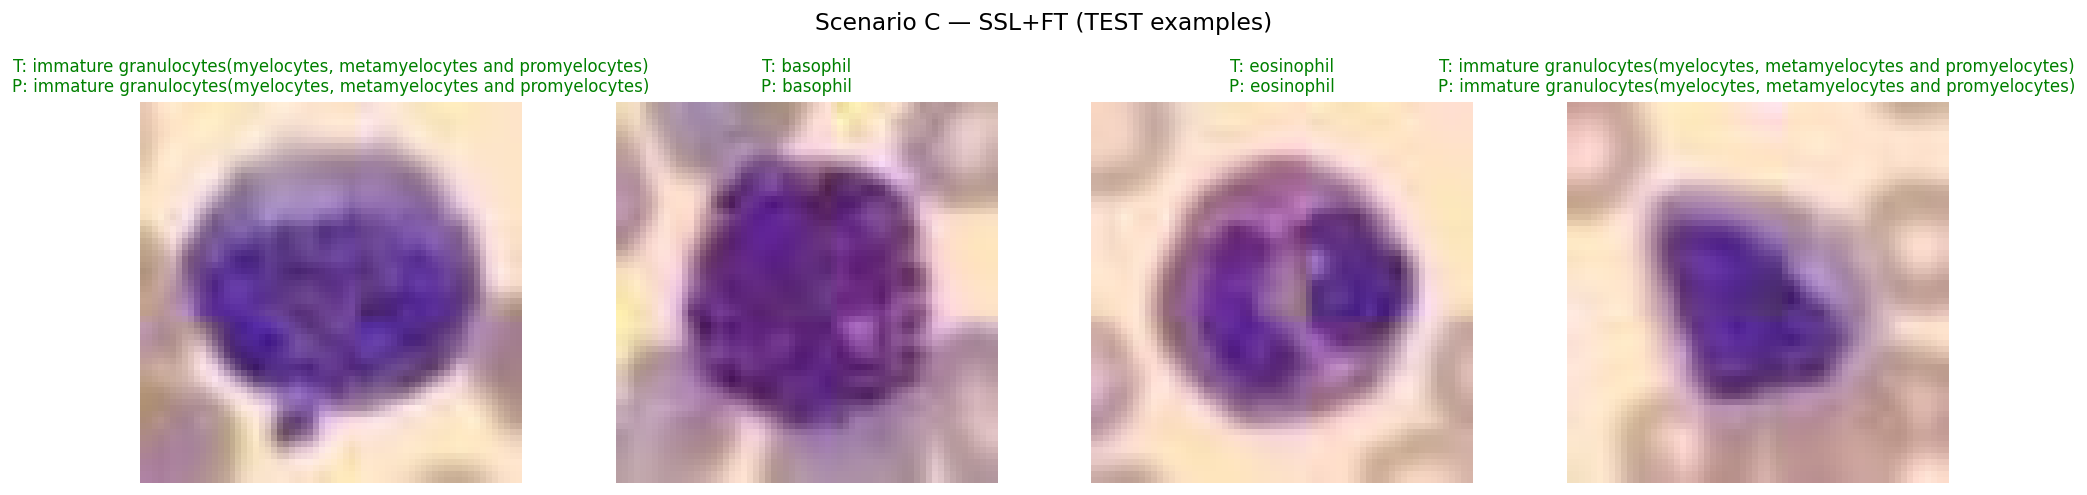

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

label_names = [info['label'][str(i)] for i in range(n_classes)]

def unnormalize(imgs, mean=0.5, std=0.5):
    """
    imgs: [B, C, H, W] tensor (normalized)
    returns: [B, C, H, W] tensor in [0,1]
    """
    imgs = imgs.clone()
    imgs = imgs * std + mean
    return torch.clamp(imgs, 0.0, 1.0)

def show_predictions(model, title, images, labels, label_names, device):
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        preds = outputs.argmax(dim=1).cpu()

    imgs = unnormalize(images)  # [B, 3, 64, 64]

    N = images.size(0)
    cols = min(4, N)
    rows = int(np.ceil(N / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows), dpi=120)
    if rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i in range(N):
        ax = axes[i]
        img = imgs[i].permute(1, 2, 0).cpu().numpy()  # [H,W,C]
        img = np.clip(img, 0, 1)

        true_idx = int(labels[i].item())
        pred_idx = int(preds[i].item())
        ok = (true_idx == pred_idx)

        ax.imshow(img)
        ax.set_title(
            f"T: {label_names[true_idx]}\nP: {label_names[pred_idx]}",
            color=("green" if ok else "red"),
            fontsize=10
        )
        ax.axis("off")

    for j in range(N, len(axes)):
        axes[j].axis("off")

    fig.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

images_test, labels_test = next(iter(test_loader_sup))

N_SHOW = min(4, images_test.size(0))
images_test = images_test[:N_SHOW]
labels_test = labels_test[:N_SHOW].squeeze().long()

# A: Scratch
try:
    show_predictions(model_a, "Scenario A — Scratch (TEST examples)",
                     images_test, labels_test, label_names, DEVICE)
except NameError:
    print("model_a not found (train Scenario A first).")

# B: ImageNet-FT
try:
    show_predictions(model_b, "Scenario B — ImageNet-FT (TEST examples)",
                     images_test, labels_test, label_names, DEVICE)
except NameError:
    print("model_b not found (train Scenario B first).")

# C: SSL+FT
try:
    show_predictions(model_c, "Scenario C — SSL+FT (TEST examples)",
                     images_test, labels_test, label_names, DEVICE)
except NameError:
    print("model_c not found (train Scenario C first).")
